***Drone EOMs***\
This notebook details the EOMs of a drone anf simulates its trajectory based on the requirements.\

• The drone model shall have 6 degrees of freedom (center of mass
motion plus attitude) and account for gravity and lift generated from 4
rotors.\
• The drone model shall be able to modify its state and attitude solely
through increasing or decreasing the number of revolutions per second of
its 4 rotor blades, as determined by the motor torques.\
• The modeled drone shall be able to achieve the performance goals
as outlined in section 4, without exhausting its power supply.\
• The model as determined through its parameters such as mass,
power consumption, engine torques and rotor blade size shall be realistic
and implementable, preferably through the use of off-the-shelf parts. In
particular, the mass of the drone shall be between 0.1kg and 10kg.

In [175]:
import numpy as np
import sympy as sym
sym.init_printing()

In [176]:
grav = 9.81 # The acceleration due to gravity in m/s^2
t1, t2, t3, t4 = sym.symbols('tau_1 tau_2 tau_3 tau_4')

Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.00466 # The mass of the quadrotor in kg
l = 0.127       # The distance from the quadrotor frame to the mocap markers in meters
C_l = 0.86        # The lift coefficient
mass = 0.86      # The mass of the quad (kg)

In [177]:
# Define position
px, py, pz = sym.symbols('p_x, p_y, p_z')
p = sym.Matrix([[px],
                    [py],
                    [pz]])

# Define velocity (in body frame)
vx, vy, vz = sym.symbols('v_x, v_y, v_z')
v = sym.Matrix([[vx],
                    [vy],
                    [vz]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities (in body frame)
wx, wy, wz = sym.symbols('omega_x, omega_y, omega_z')
w = sym.Matrix([[wx],
                [wy],
                [wz]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_to_W = Rz @ Ry @ Rx
R_to_B = R_to_W.T

# Define the thrust and torques generated by each rotor
thrust = sym.Matrix([[0],
                     [0],
                     [C_l*(t1 + t2 + t3 + t4)]])

# Rotate the thrust vector into the world frame
thrust_inW = R_to_W @ thrust

grav_in_W = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])

# final translational dynamics
F = (thrust_inW + grav_in_W) / mass
F



⎡1.16279069767442⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ))⋅(0.86⋅τ₁ + 0.86⋅τ₂ + 
⎢                                                                             
⎢1.16279069767442⋅(-sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ))⋅(0.86⋅τ₁ + 0.86⋅τ₂ +
⎢                                                                             
⎣         1.16279069767442⋅(0.86⋅τ₁ + 0.86⋅τ₂ + 0.86⋅τ₃ + 0.86⋅τ₄)⋅cos(φ)⋅cos(

0.86⋅τ₃ + 0.86⋅τ₄) ⎤
                   ⎥
 0.86⋅τ₃ + 0.86⋅τ₄)⎥
                   ⎥
θ) - 9.81          ⎦

In [178]:
# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])


# Define the torques generated by each rotor
tau = sym.Matrix([[l*C_l*(t1 - t3)],
                  [l*C_l*(t2 - t4)],
                  [(t1 - t2 + t3 - t4)]])

# Compute the angular acceleration in the body frame
# tau_inB = R_to_B @ tau
w_dot = I_inB.inv() @ (tau - w.cross(I_inB @ w))

# final rotational dynamics
w_dot




⎡        -1.02608695652174⋅ω_y⋅ω_z + 47.4869565217391⋅τ₁ - 47.4869565217391⋅τ₃
⎢                                                                             
⎢         1.02608695652174⋅ωₓ⋅ω_z + 47.4869565217391⋅τ₂ - 47.4869565217391⋅τ₄ 
⎢                                                                             
⎣214.592274678112⋅τ₁ - 214.592274678112⋅τ₂ + 214.592274678112⋅τ₃ - 214.5922746

        ⎤
        ⎥
        ⎥
        ⎥
78112⋅τ₄⎦

In [179]:
# cocatenate the translational and rotational dynamics
pdot = sym.Matrix.vstack(v)
ang_dot = sym.Matrix.vstack(w)
X_dot = sym.Matrix.vstack(pdot, F, ang_dot, w_dot)
X_dot

⎡                                               vₓ                            
⎢                                                                             
⎢                                              v_y                            
⎢                                                                             
⎢                                              v_z                            
⎢                                                                             
⎢1.16279069767442⋅(sin(φ)⋅sin(ψ) + sin(θ)⋅cos(φ)⋅cos(ψ))⋅(0.86⋅τ₁ + 0.86⋅τ₂ + 
⎢                                                                             
⎢1.16279069767442⋅(-sin(φ)⋅cos(ψ) + sin(ψ)⋅sin(θ)⋅cos(φ))⋅(0.86⋅τ₁ + 0.86⋅τ₂ +
⎢                                                                             
⎢         1.16279069767442⋅(0.86⋅τ₁ + 0.86⋅τ₂ + 0.86⋅τ₃ + 0.86⋅τ₄)⋅cos(φ)⋅cos(
⎢                                                                             
⎢                                               ωₓ  

In [180]:
# Finding the equilibrium points of the system
# Define the equilibrium point
p_eq = np.array([0., 0., 0.])
v_eq = np.array([0., 0., 0.])
ang_eq = np.array([[0.], [0.], [0.]]).flatten()
w_eq = np.array([[0.], [0.], [0.]]).flatten()
tau_eq = np.array([[mass*grav/4], [mass*grav/4], [mass*grav/4], [mass*grav/4]]).flatten()
tau_eq /= C_l
# plug equilibrium values into the state rate vector
f_eq = X_dot.subs({px: p_eq[0], py: p_eq[1], pz: p_eq[2],
                     vx: v_eq[0], vy: v_eq[1], vz: v_eq[2],
                     phi: ang_eq[0], theta: ang_eq[1], psi: ang_eq[2],
                     wx: w_eq[0], wy: w_eq[1], wz: w_eq[2],
                     t1: tau_eq[0], t2: tau_eq[1], t3: tau_eq[2], t4: tau_eq[3],
                    })
print("The state rate vector at the equilibrium point:")
sym.N(f_eq,3)


The state rate vector at the equilibrium point:


⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

In [181]:
# Linearize the system
# A_ = f_eq.jacobian(X_dot)
A_ = sym.lambdify([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, t1, t2, t3, t4], X_dot.jacobian([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz]), 'numpy')
# substitute the equilibrium values into the A matrix
A_lin = sym.Matrix(A_(p_eq[0], p_eq[1], p_eq[2], v_eq[0], v_eq[1], v_eq[2], ang_eq[0], ang_eq[1], ang_eq[2], w_eq[0], w_eq[1], w_eq[2], tau_eq[0], tau_eq[1], tau_eq[2], tau_eq[3]))
B_ = sym.lambdify([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, t1, t2, t3, t4], X_dot.jacobian([t1, t2, t3, t4]), 'numpy')
B_lin = sym.Matrix(B_(p_eq[0], p_eq[1], p_eq[2], v_eq[0], v_eq[1], v_eq[2], ang_eq[0], ang_eq[1], ang_eq[2], w_eq[0], w_eq[1], w_eq[2], tau_eq[0], tau_eq[1], tau_eq[2], tau_eq[3]))
print("The A matrix and B Matrix:")
A_lin, B_lin



The A matrix and B Matrix:


⎛⎡0  0  0  1.0   0    0           0                 0          0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0   1.0   0           0                 0          0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0    0   1.0          0                 0          0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0    0    0           0          9.81000000000001  0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0    0    0   -9.81000000000001         0          0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0    0    0           0                 0          0   0    0    0
⎜⎢                                                                            
⎜⎢0  0  0   0    0    0           0                 

In [182]:
# Hovering in the air for 2 minutes
# Define the desired position
p_d = sym.Matrix([[0.], [0.], [1.]])

# Define the desired velocity
v_d = sym.Matrix([[0.], [0.], [0.]])
# Define the desired roll, pitch, and yaw angles
phi_d = 0.
theta_d = 0.
psi_d = 0.

# Define the desired angular velocities
wx_d = 0.
wy_d = 0.
wz_d = 0.

# cocatenate the desired states
x_d = np.vstack((p_d, v_d, phi_d, theta_d, psi_d, wx_d, wy_d, wz_d))
x_d

array([[0],
       [0],
       [1.00000000000000],
       [0],
       [0],
       [0],
       [0.0],
       [0.0],
       [0.0],
       [0.0],
       [0.0],
       [0.0]], dtype=object)

In [183]:
# create a for loop to simulate the system for 2 minutes
# Define the time step
dt = 0.001
# Define the number of time steps
N = 1200
# Initialize the state vector
x = np.zeros((12, N))
# Initialize the control vector
u = np.zeros((4, N))
# Initialize the time vector
t = np.zeros((N, 1))

# Define the initial state
x[:, 0] = np.array([[p_eq[0]], [p_eq[1]], [1.], [v_eq[0]], [v_eq[1]], [v_eq[2]], [ang_eq[0]], [ang_eq[1]], [ang_eq[2]], [w_eq[0]], [w_eq[1]], [w_eq[2]]]).flatten()

# Define the control input
u[:, 0] = tau_eq

K = np.array([[1.0, 1., 1., 1.0], [1.0, 1., 1., 1.0], [1.0, 1.0, 1., 1.0]]).T

# Simulate the system
for i in range(1, N):
    # Compute the control input
    e = np.array([x[:3, i-1] - x_d[:3].flatten()]).flatten()
    u[:, i] = tau_eq
    # Compute the state rate vector
    f = X_dot.subs({px: x[0, i-1], py: x[1, i-1], pz: x[2, i-1],
                     vx: x[3, i-1], vy: x[4, i-1], vz: x[5, i-1],
                     phi: x[6, i-1], theta: x[7, i-1], psi: x[8, i-1],
                     wx: x[9, i-1], wy: x[10, i-1], wz: x[11, i-1],
                     t1: u[0, i], t2: u[1, i], t3: u[2, i], t4: u[3, i],
                    })
    # Update the state vector
    x[:, i] = x[:, i-1] + np.array(f).flatten()*dt
    # Update the time vector
    t[i] = t[i-1] + dt

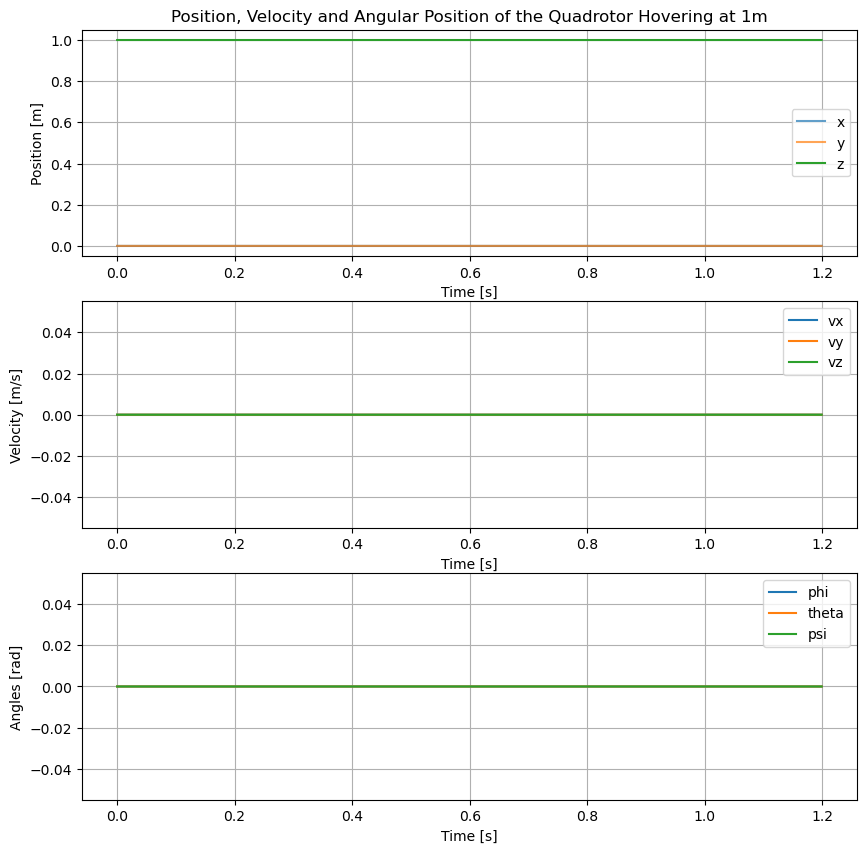

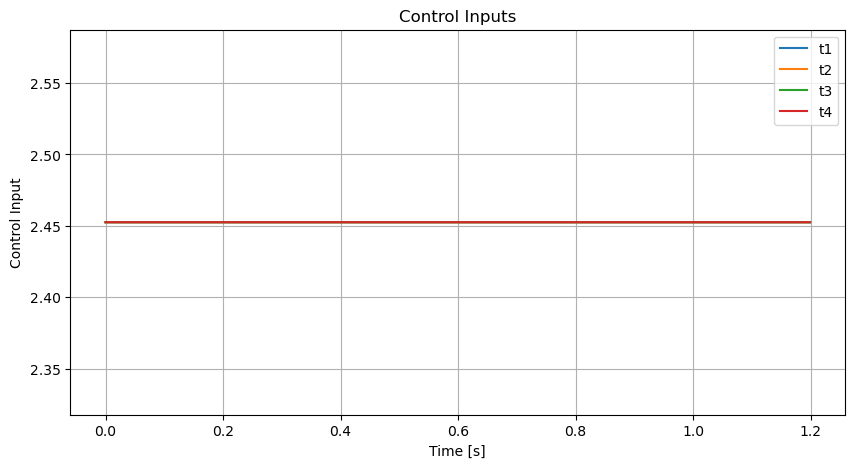

In [184]:
# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(t, x[0, :], label='x', alpha=0.7)
plt.plot(t, x[1, :], label='y', alpha=0.7)
plt.plot(t, x[2, :], label='z')
plt.title('Position, Velocity and Angular Position of the Quadrotor Hovering at 1m')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, x[3, :], label='vx')
plt.plot(t, x[4, :], label='vy')
plt.plot(t, x[5, :], label='vz')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, x[6, :], label='phi')
plt.plot(t, x[7, :], label='theta')
plt.plot(t, x[8, :], label='psi')
plt.xlabel('Time [s]')      
plt.ylabel('Angles [rad]')
plt.legend()
plt.grid()
plt.show()

# Plot the control inputs
plt.figure(figsize=(10, 5))
plt.plot(t, u[0, :], label='t1')
plt.plot(t, u[1, :], label='t2')
plt.plot(t, u[2, :], label='t3')
plt.plot(t, u[3, :], label='t4')
plt.title('Control Inputs')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.legend()
plt.grid()
plt.show()



In [213]:
# Simulate the drone moving in a circle with a fixed radius of 2 meters with a constant height of 1 meter with a speed of 0.5 for 1 minute
# Constraints:
# norm(v) = 0.5

# Define the time step
dt = 0.1
# Define the number of time steps
N = 600
# Initialize the state vector
x = np.zeros((12, N))
# Initialize the control vector
u = np.zeros((4, N))
# Initialize the time vector
t = np.zeros((N, 1))

v = 0.5 # m/s

# Define the initial state
x[:, 0] = np.array([[0.], [2.], [1.], [v], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.]]).flatten()

angle = np.arctan(0.5**2/(9.81*2))

r1 = (np.sqrt(mass*9.81/(4*C_l*np.cos(angle))))
r3 = r1
r2 = r1 * 2
r4 = r2

# Simulate the system
for i in range(1, N):
    # Compute the control input
    u[:, i] = np.array([r2, r1, r3, r4])
    # Compute the state rate vector
    dx = X_dot.subs({px: x[0, i-1], py: x[1, i-1], pz: x[2, i-1],
                     vx: x[3, i-1], vy: x[4, i-1], vz: x[5, i-1],
                     phi: x[6, i-1], theta: x[7, i-1], psi: x[8, i-1],
                     wx: x[9, i-1], wy: x[10, i-1], wz: x[11, i-1],
                     t1: u[0, i], t2: u[1, i], t3: u[2, i], t4: u[3, i]
                    })
    # print(dx)
    dx[2] = 0
    dx[5] = 0
    dx[0] = v*np.cos(t[i-1])
    dx[1] = v*np.sin(t[i-1])
    dx[3] = -v * np.sin(t[i-1] * (v/2))
    dx[4] = v * np.cos(t[i-1] * (v/2))
    # Update the state vector
    x[:, i] = x[:, i-1] + np.array(dx).flatten()*dt
    # Update the time vector
    t[i] = t[i-1] + dt


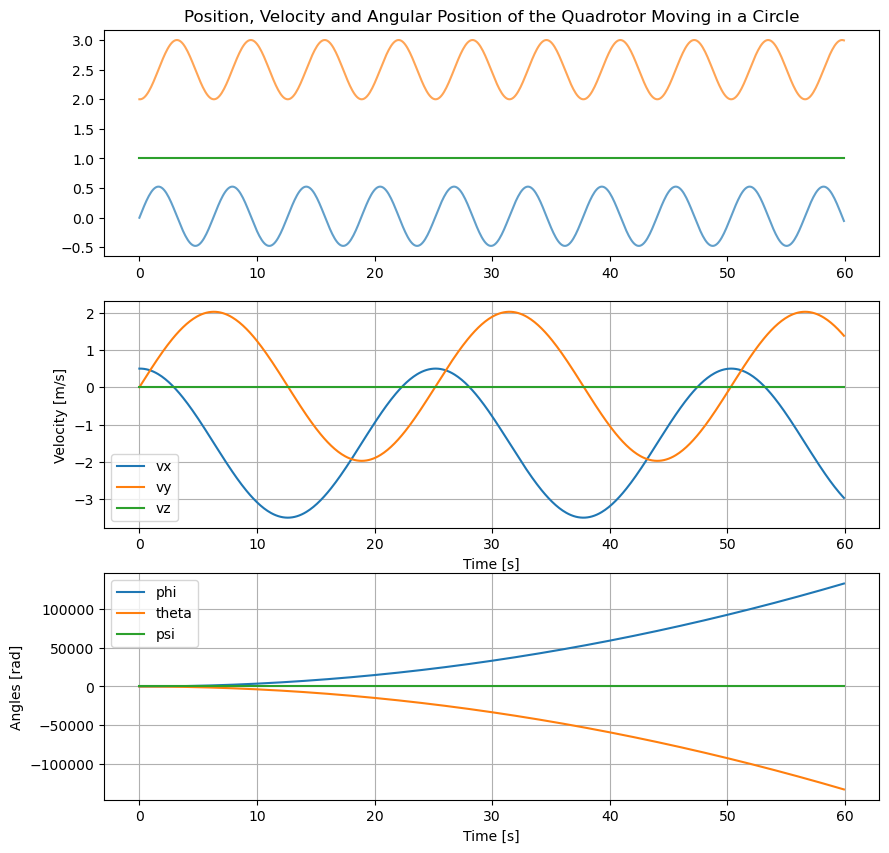

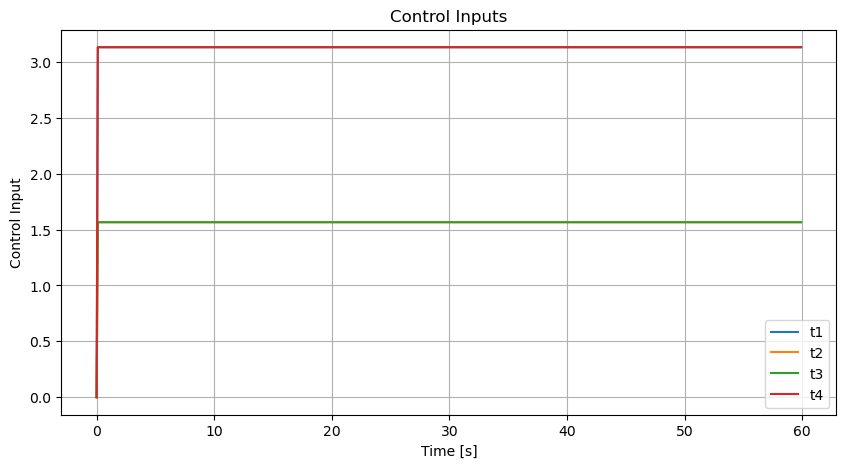

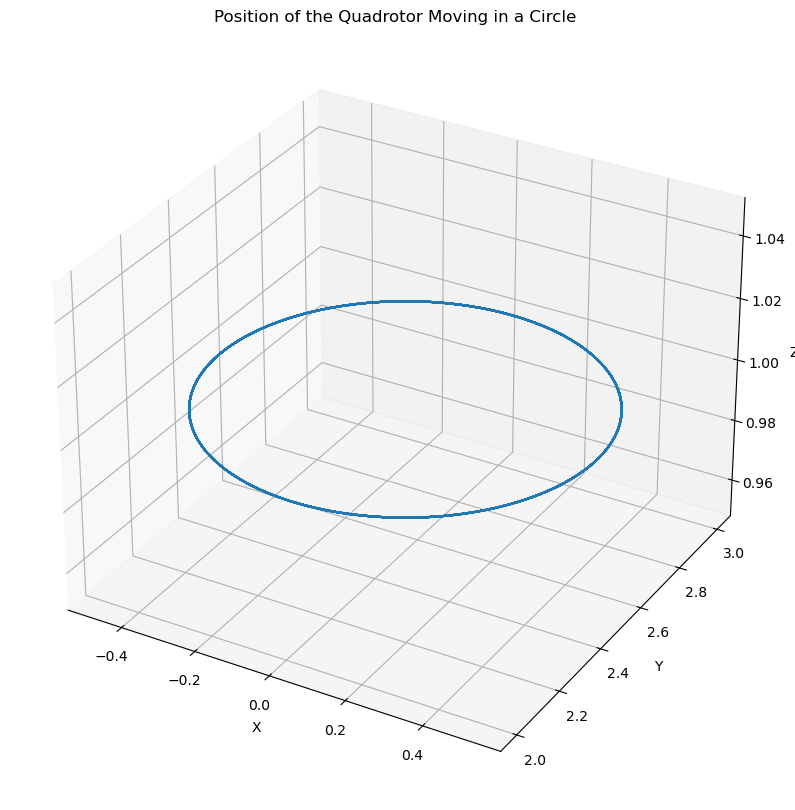

In [199]:
# Plot the results
# Plotting the position in a 3d plot
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.title('Position, Velocity and Angular Position of the Quadrotor Moving in a Circle')
plt.plot(t, x[0, :], label='x', alpha=0.7)
plt.plot(t, x[1, :], label='y', alpha=0.7)
plt.plot(t, x[2, :], label='z')

plt.subplot(3, 1, 2)
plt.plot(t, x[3, :], label='vx')
plt.plot(t, x[4, :], label='vy')
plt.plot(t, x[5, :], label='vz')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, x[6, :], label='phi')
plt.plot(t, x[7, :], label='theta')
plt.plot(t, x[8, :], label='psi')
plt.xlabel('Time [s]')
plt.ylabel('Angles [rad]')
plt.legend()
plt.grid()
plt.show()

# Plot the control inputs
plt.figure(figsize=(10, 5))
plt.plot(t, u[0, :], label='t1')
plt.plot(t, u[1, :], label='t2')
plt.plot(t, u[2, :], label='t3')
plt.plot(t, u[3, :], label='t4')
plt.title('Control Inputs')
plt.xlabel('Time [s]')
plt.ylabel('Control Input')
plt.legend()
plt.grid()
plt.show()


# plot the position of the quadrotor going in a circle in 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[0, :], x[1, :], x[2, :])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Position of the Quadrotor Moving in a Circle')
plt.show()

